In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import shutil
import cv2

!pip install imutils

from imutils import paths

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
project_path = '/content/gdrive/My Drive/Kaggle/covid19-xray'
dataset_path = project_path + '/dataset'
os.environ['KAGGLE_CONFIG_DIR'] = '/content/gdrive/My Drive/Kaggle'

%cd /content/gdrive/My Drive/Kaggle/covid19-xray

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Kaggle/covid19-xray


In [0]:
%%bash
rm -rf dataset
mkdir -p dataset/covid
mkdir -p dataset/normal
mkdir -p input/covid-chest-xray
mkdir -p input/chest-xray-pneumonia/chest_xray

In [0]:
# download covid dataset
covid_dataset_path = project_path + '/input/covid-chest-xray'
%cd /content/gdrive/My Drive/Kaggle/covid19-xray/input/covid-chest-xray

!kaggle datasets download -d bachrr/covid-chest-xray
!unzip -qq \*.zip
%rm *.zip

/content/gdrive/My Drive/Kaggle/covid19-xray/input/covid-chest-xray
 95% 201M/211M [00:04<00:00, 47.2MB/s]
100% 211M/211M [00:04<00:00, 53.6MB/s]
replace annotations/imageannotation_ai_lung_bounding_boxes.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [0]:
# construct the path to the metadata CSV file and load it
csvPath = os.path.sep.join([covid_dataset_path, "metadata.csv"])
df = pd.read_csv(csvPath)

# loop over the rows of the COVID-19 data frame
for (i, row) in df.iterrows():
    # if (1) the current case is not COVID-19 or (2) this is not
    # a 'PA' view, then ignore the row
    if row["finding"] != "COVID-19" or row["view"] != "PA":
        continue

    # build the path to the input image file
    imagePath = os.path.sep.join([covid_dataset_path, "images", row["filename"]])

    # if the input image file does not exist (there are some errors in
    # the COVID-19 metadeta file), ignore the row
    if not os.path.exists(imagePath):
        continue

    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = row["filename"].split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/covid", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

In [0]:
# download pneumonia dataset
pneumonia_dataset_path = project_path + '/input/chest-xray-pneumonia/chest_xray'
%cd /content/gdrive/My Drive/Kaggle/covid19-xray/input/chest-xray-pneumonia

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -qq \*.zip
%rm *.zip

/content/gdrive/My Drive/Kaggle/covid19-xray/input/chest-xray-pneumonia
100% 2.29G/2.29G [00:31<00:00, 47.4MB/s]
100% 2.29G/2.29G [00:31<00:00, 77.8MB/s]


In [0]:
# build normal xray dataset
samples = 25
basePath = os.path.sep.join([pneumonia_dataset_path, "train", "NORMAL"])
imagePaths = list(paths.list_images(basePath))

# randomly sample the image paths
random.seed(42)
random.shuffle(imagePaths)
imagePaths = imagePaths[:samples]

# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = imagePath.split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/normal", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

In [0]:
def plots_from_files(imspaths, title, rows=1):
    """Plot the images in a grid"""
    f = plt.figure(figsize=(10,5))
    plt.suptitle(title, fontsize=10)
    totalIms = len(imspaths)
    for i in range(totalIms):
        sp = f.add_subplot(rows, -(-totalIms // rows), i + 1)
        sp.axis('Off')
        img = plt.imread(imspaths[i])
        plt.imshow(img)

normal_images = list(paths.list_images(f"{dataset_path}/normal"))
covid_images = list(paths.list_images(f"{dataset_path}/covid"))

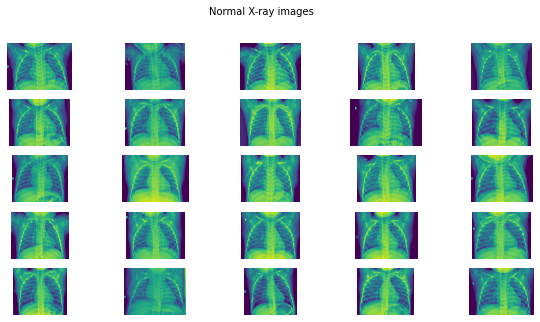

In [4]:
plots_from_files(normal_images, title="Normal X-ray images", rows=5)

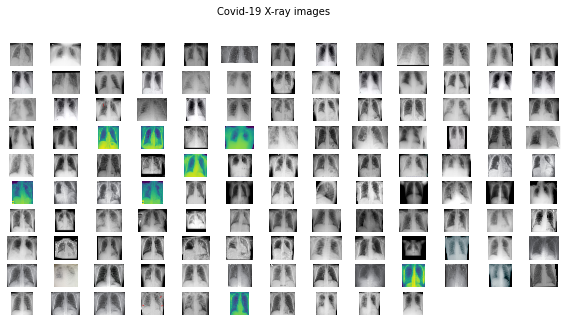

In [5]:
plots_from_files(covid_images, title="Covid-19 X-ray images", rows=10)

In [0]:
imagePaths = list(paths.list_images(dataset_path))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
labels = np.array(labels)

data = np.array(data) / 255.0 # normalize data

In [0]:
# perform one-hot encoding on the labels
from sklearn.preprocessing import LabelBinarizer
from keras.utils import to_categorical

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [0]:
# split the data (cross-validation 80-20)
from sklearn.model_selection import train_test_split

(X_train, X_val, y_train, y_val) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [0]:
# build model
from keras.applications.vgg16 import VGG16
from keras.layers import Input, AveragePooling2D, Flatten, Dense, Dropout
from keras.models import Model

# load the VGG16 network, ensuring the head FC layer sets are left
model_vgg16_conv = VGG16(weights="imagenet", include_top=False)
# Make vgg16 model layers as non trainable
for layer in model_vgg16_conv.layers:
    layer.trainable = False

input = Input(shape=(224, 224, 3))
# use the generated model 
output_vgg16_conv = model_vgg16_conv(input)

# add the fully-connected layers
head_model = AveragePooling2D(pool_size=(4, 4))(output_vgg16_conv)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(64, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(2, activation="softmax")(head_model)

model = Model(inputs=input, outputs=head_model)

In [0]:
epochs = 10
learning_rate = 1e-3

from keras.optimizers import Adam

opt = Adam(lr=learning_rate, decay=learning_rate / epochs)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [0]:
# initialize the training data augmentation object
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

In [23]:
batch_size = 8

# train the head of the network
history = model.fit_generator(
  train_datagen.flow(X_train, y_train, batch_size=batch_size),
  steps_per_epoch=len(trainX) // batch_size,
  validation_data=(X_val, y_val),
  validation_steps=len(X_val) // batch_size,
  epochs=epochs
)

Epoch 1/10
15/15 [==============================] - 8s 503ms/step - loss: 0.5317 - accuracy: 0.7333 - val_loss: 0.5027 - val_accuracy: 0.8387
Epoch 2/10
15/15 [==============================] - 1s 87ms/step - loss: 0.4931 - accuracy: 0.8113 - val_loss: 0.3866 - val_accuracy: 0.8387
Epoch 3/10
15/15 [==============================] - 1s 85ms/step - loss: 0.3501 - accuracy: 0.8319 - val_loss: 0.3385 - val_accuracy: 0.8387
Epoch 4/10
15/15 [==============================] - 1s 83ms/step - loss: 0.3803 - accuracy: 0.8230 - val_loss: 0.2967 - val_accuracy: 0.8387
Epoch 5/10
15/15 [==============================] - 1s 83ms/step - loss: 0.2657 - accuracy: 0.8673 - val_loss: 0.2672 - val_accuracy: 0.8387
Epoch 6/10
15/15 [==============================] - 1s 85ms/step - loss: 0.2417 - accuracy: 0.8850 - val_loss: 0.2391 - val_accuracy: 0.8710
Epoch 7/10
15/15 [==============================] - 1s 84ms/step - loss: 0.2368 - accuracy: 0.9027 - val_loss: 0.2086 - val_accuracy: 0.9355
Epoch 8/10
1

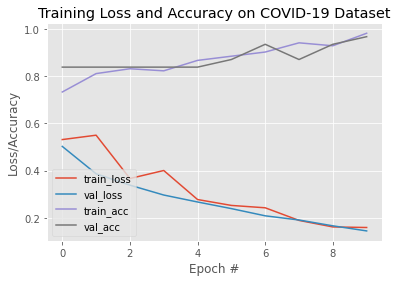

In [26]:
plt.style.use("ggplot")
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")